<a href="https://colab.research.google.com/github/mohansameer1983/NLP/blob/main/MMAI_891_Wysdom_Assignment_Fine_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, AutoTokenizer, AutoModel, AutoConfig
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, AutoTokenizer, AutoModel, AutoConfig

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

import tensorflow_datasets as tfds

import re

import yellowbrick

     |████████████████████████████████| 4.0 MB 8.6 MB/s 
     |████████████████████████████████| 4.3 MB 37.0 MB/s 
     |████████████████████████████████| 6.6 MB 49.8 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 


In [2]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [3]:
def load_data(file_path):
  data_df = pd.read_csv(file_path)
  return data_df

orig_data = load_data('/content/drive/MyDrive/Colab Notebooks/data/public_data.csv')
orig_data

,id,message,label
0,10480,start the robotic vacuum,iot_cleaning
1,4210,i am sorry but i think you are not right.,general_negate
2,2443,what is the time difference between california...,datetime_convert
3,5869,tell me my list names,lists_query
4,2801,beep when i get an email from john,email_query
...,...,...,...
8879,9708,search for a train ticket to newcastle,transport_ticket
8880,8278,is there a food festival in the area,recommendation_events
8881,10509,make the lights blue in here,iot_hue_lightchange
8882,7046,play from favorites song,play_music


In [4]:
orig_data.drop_duplicates(inplace= True)

In [5]:
orig_data.isna().sum()

id         0
message    0
label      0
dtype: int64

In [6]:
max_words = []
for row in orig_data['message']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 25


#Split Data

## Training Data Split

In [7]:
def extract_text_and_y(df, test_size):

  text = df['message'].tolist()

  le = LabelEncoder()
  df['label_encoded'] = le.fit_transform(df['label'])
  y = df['label_encoded']

  label_dict = (df[['label','label_encoded']].drop_duplicates()
              .sort_values(by='label_encoded')
              .reset_index(drop=True)['label']
              .to_dict())
  


  X_train, X_val, y_train, y_val = train_test_split(text, y, test_size=test_size, random_state=2)
  return X_train, X_val, y_train, y_val, label_dict

# the following prepares the input for running in DistilBert
train_text, val_text, train_y, val_y, label_dict = extract_text_and_y(orig_data, 0.20)

In [8]:
val_y

3651    59
3230    57
727     36
6883    38
8022    53
        ..
6729    61
4031    45
3964    12
799     57
1716    51
Name: label_encoded, Length: 1777, dtype: int64

In [9]:
train_text

['save the information which is provided by aman on this song',
 'please raise the lights to max',
 'the song touches my heart',
 'yeap you get that perfectly.',
 'mute immediately',
 'i feel like having soup for lunch order from wangs kitchen restaurant a chicken manchow soup',
 "what's my stock fluctuations",
 'define god',
 'i like the songs of yeshudas please play it',
 "please answer jean's email",
 'set a reminder for twelve thirty meeting with the boss',
 'please dim the lights',
 'remove any kind of list',
 'want to wake up can you order a cappochino',
 'read out my list for today',
 'can you delete the doctors appointment i had tuesday',
 'send email to joanne@aol dot com and add as new contact',
 'you told me the incorrect date please correct this.',
 'turn on living room radio',
 'is mary smith in my contacts list',
 'turn socket off',
 'maximum kilometer to delivery',
 'you have done it right musch appreciated, olly.',
 'the set alarm for nine pm on thursday night',
 'descr

In [10]:
train_y

8011    38
2612    32
8642    38
3724    16
4753     4
        ..
1099    43
2514    45
6637     5
2575    41
7336    38
Name: label_encoded, Length: 7107, dtype: int64

In [11]:
label_dict

{0: 'alarm_query',
 1: 'alarm_remove',
 2: 'alarm_set',
 3: 'audio_volume_down',
 4: 'audio_volume_mute',
 5: 'audio_volume_up',
 6: 'calendar_query',
 7: 'calendar_remove',
 8: 'calendar_set',
 9: 'cooking_recipe',
 10: 'datetime_convert',
 11: 'datetime_query',
 12: 'email_addcontact',
 13: 'email_query',
 14: 'email_querycontact',
 15: 'email_sendemail',
 16: 'general_affirm',
 17: 'general_commandstop',
 18: 'general_confirm',
 19: 'general_dontcare',
 20: 'general_explain',
 21: 'general_joke',
 22: 'general_negate',
 23: 'general_praise',
 24: 'general_quirky',
 25: 'general_repeat',
 26: 'iot_cleaning',
 27: 'iot_coffee',
 28: 'iot_hue_lightchange',
 29: 'iot_hue_lightdim',
 30: 'iot_hue_lightoff',
 31: 'iot_hue_lighton',
 32: 'iot_hue_lightup',
 33: 'iot_wemo_off',
 34: 'iot_wemo_on',
 35: 'lists_createoradd',
 36: 'lists_query',
 37: 'lists_remove',
 38: 'music_likeness',
 39: 'music_query',
 40: 'music_settings',
 41: 'news_query',
 42: 'play_audiobook',
 43: 'play_game',
 44

### Visualize Data

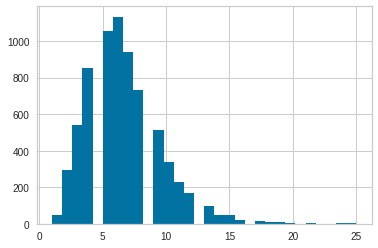

In [12]:
# Get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

## Creating Embeddings using DistilBERT 

In [13]:
#Get DistilBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
# Check longest token sequence in entire text
def checkForMaxTokenSeqInData(text_list, tokenizer_i):
  
    max_val = 0
    for sent in text_list:
        try:
            sent_tok_len = len(tokenizer_i.tokenize(sent))
            max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
        except:
            pass
    
    print(f"The maximum amount of tokens in the dataset is {max_val}")
    return max_val

MAX_VAL = checkForMaxTokenSeqInData(train_text+val_text,tokenizer)
#MAX_VAL = 28

The maximum amount of tokens in the dataset is 28


In [17]:

def encode_text(tokenizer_i, text, max_text_length):

    # Encode the sentence
    encodedText = tokenizer(
                        text,  # document to encode.
                        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
                        max_length=max_text_length,  # set max length
                        truncation=True,  # truncate longer messages
                        padding='max_length', 
                        return_attention_mask=True,  # create attn. masks
                        return_token_type_ids=True
                    )
    return encodedText

train_encoding = encode_text(tokenizer, train_text, MAX_VAL)
val_encoding = encode_text(tokenizer, val_text, MAX_VAL)


In [18]:
train_encoding

{'input_ids': [[101, 3828, 1996, 2592, 2029, 2003, 3024, 2011, 25933, 2078, 2006, 2023, 2299, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3531, 5333, 1996, 4597, 2000, 4098, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 2299, 12817, 2026, 2540, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 6300, 9331, 2017, 2131, 2008, 6669, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 20101, 3202, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2514, 2066, 2383, 11350, 2005, 6265, 2344, 2013, 7418, 2015, 3829, 4825, 1037, 7975, 2158, 9905, 2860, 11350, 102, 0, 0, 0, 0, 0, 0, 0], [101, 2054, 1005, 1055, 2026, 4518, 28892, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9375, 2643, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2066, 1996, 2774, 1997, 2748, 6979, 8883, 3531, 2377, 2009, 102, 0, 0,

# Modelling

## Build and Train Model

In [19]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
def build_model(base_model, trainable=False, params={}):
    inputs = Input(shape = (params['max_seq_length'],),name='input_ids', dtype='int32')
    masks  = Input(shape = (params['max_seq_length'],),name='attention_mask', dtype='int32')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, masks)[0]
    cls_token = dbert_output[:, 0, :]
    dropout_layer = Dropout(params['dropout_rate_1'])(cls_token)
    dense_layer = Dense(params['dense_layer_1_units'],activation='relu')(dropout_layer)
    dropout_layer = Dropout(params['dropout_rate_1'])(dense_layer)
    dense_layer = Dense(params['dense_layer_2_units'],activation='relu')(dropout_layer)
    dropout_layer = Dropout(params['dropout_rate_2'])(dense_layer)
    flatten = Flatten()(dropout_layer)
    probs = Dense(len(label_dict), activation='softmax', name="output")(flatten)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

MODEL_NAME= 'distilbert-base-uncased'

# Configure DistilBERT's initialization
config = DistilBertConfig(output_hidden_states=False)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
params={
        "dense_layer_1_units": 128,        
        "dropout_rate_1": 0.2,
	      "dense_layer_2_units": 32,
        "dropout_rate_2": 0.2,
        "regularizer_l2_rate":0.01,
        "max_seq_length":MAX_VAL
        }

model = build_model(dbert_model, trainable=False, params=params)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 28)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 28)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 28, 768),                                                    
                                 hidden_states=None                                           

In [23]:
def compile_model(model, lr):

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.sparse_categorical_crossentropy
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics='accuracy')
    return model


model = compile_model(model, 0.003)

In [24]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/NLP/distilBert_text_classification_model_weights.hdf5', save_best_only = True, save_weights_only=True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [25]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):

    dataset_train = tf.data.Dataset.from_tensor_slices((dict(model_inputs_and_masks_train),y_train))
    dataset_val = tf.data.Dataset.from_tensor_slices((dict(model_inputs_and_masks_val),y_val))

    history = model.fit(dataset_train.shuffle(len(dataset_train)).batch(batch_size), 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                    validation_data=dataset_val.shuffle(len(dataset_val)).batch(batch_size), 
                    verbose=1,
                    callbacks=[tl_checkpoint_1,EarlyStoppingCallback])
    
    return model, history, dataset_val

tf.config.run_functions_eagerly(True) #use function decorator in TF 2.0, please enable run function eagerly by using below line after importing TensorFlow
model, history, val_dataset = train_model(model, train_encoding, val_encoding, train_y, val_y, batch_size=32, num_epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


223/223 [==============================] - 59s 263ms/step - loss: 2.4776 - accuracy: 0.3632 - val_loss: 1.1986 - val_accuracy: 0.6854
Epoch 2/50
223/223 [==============================] - 59s 264ms/step - loss: 1.3181 - accuracy: 0.6232 - val_loss: 0.8808 - val_accuracy: 0.7552
Epoch 3/50
223/223 [==============================] - 58s 260ms/step - loss: 1.0771 - accuracy: 0.6827 - val_loss: 0.7198 - val_accuracy: 0.8036
Epoch 4/50
223/223 [==============================] - 58s 260ms/step - loss: 0.9244 - accuracy: 0.7232 - val_loss: 0.6856 - val_accuracy: 0.8059
Epoch 5/50
223/223 [==============================] - 58s 261ms/step - loss: 0.8579 - accuracy: 0.7421 - val_loss: 0.6329 - val_accuracy: 0.8149
Epoch 6/50
223/223 [==============================] - 58s 261ms/step - loss: 0.8270 - accuracy: 0.7559 - val_loss: 0.6052 - val_accuracy: 0.8210
Epoch 7/50
223/223 [==============================] - 56s 251ms/step - loss: 0.7733 - accuracy: 0.7591 - val_loss: 0.6364 - val_accuracy: 0.8

# Predict & Calculate Score

In [ ]:
# Validation data - Tensor Conversion
def predict_labels(model, dataset_val):
  output_val = model.predict(dataset_val)
  predicted_labels = np.argmax(output_val, axis=1)
  return predicted_labels

predicted_labels = predict_labels(model, val_dataset)
predicted_labels

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
# Calculate Scores
def calculate_score(val_y, predicted_labels):
  ari_val = adjusted_rand_score(val_y, predicted_labels)
  ami_val = adjusted_mutual_info_score(val_y, predicted_labels, average_method='arithmetic')
  print("ari_val:", ari_val)
  print("ami_val:", ami_val)
  return

calculate_score(val_y, predicted_labels)

#Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def run_classification_report(test_y, pred_labels):
  report = classification_report(test_y, pred_labels, output_dict=True)

  df = pd.DataFrame(report)

  df.drop(columns=['accuracy', 'macro avg','weighted avg'], inplace=True)
  df = df.transpose()
  ser = pd.Series(label_dict)

  df = df.assign(Topics=ser.values)
  df.set_index('Topics', inplace=True)
  df=df.round(decimals = 2)
  return df


df= run_classification_report(val_y, predicted_labels)
df

#Visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(val_y, predicted_labels, label_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(val_y, predicted_labels, target_names=list(label_dict.values()))

plot_classification_report(classificationReport)

#Conclusion


1.   Recall is a good inidicator here to tell us how well we have identified topics.
2.   Topics not identified well by model - general_quirky, iot_hue_lighton
3.   'iot_hue_lighton' have very low number of records, compared to other topics, and could be the reason for low recall rate.
4.   'general_quirky' have low recall rate, even with good number of samples. After looking at the data for this topic, looks like conversations under this topic are even confusing for human being. This is why model is performing well.





#Result Submission

In [ ]:
result_df = load_data('/content/drive/MyDrive/Colab Notebooks/data/input_data.csv')
result_df

In [ ]:
def get_submission_predicted_labels(result_sub_df, model_param):  
  test_text = result_sub_df['message'].tolist()

  test_encoding = encode_text(tokenizer, test_text, MAX_VAL)
  test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encoding)))
  output_val = model_param.predict(test_dataset)
  predicted_labels = np.argmax(output_val, axis=1)
  return predicted_labels

predicted_labels=get_submission_predicted_labels(result_df, model)  

In [ ]:
predicted_labels

In [ ]:
def create_submission_file(labels_predicted, label_dict_param, filepath):
  my_submission = pd.DataFrame({'Id': result_df['id'], 'label': labels_predicted})
  my_submission['label'] = my_submission['label'].map(label_dict_param)
  print(my_submission.head())

  # NOTE: after saving the CSV file, be sure to zip the file before submitting to the competition website!
  my_submission.to_csv(filepath, index=False)
  return

create_submission_file(predicted_labels, label_dict, '/content/drive/MyDrive/Colab Notebooks/data/submission_custom_distillbert.csv')

#Fine Tuning Custom DistilBERT Model

In [ ]:
# Unfreeze distilBERT layers and make available for training
def fine_tune_transfer_learning_model(base_transfomer_model, custom_model, learning_rate):

    base_transfomer_model.trainable = True
    
    # Recompile model after unfreezing
    model_updated = compile_model(custom_model, learning_rate)
    custom_model.summary()
    
    model_updated, history2, val_dataset1 = train_model(model, train_encoding, val_encoding, train_y, val_y, batch_size=32, num_epochs=10)

    return custom_model, history2, val_dataset1

model2, history2, val_dataset2=fine_tune_transfer_learning_model(dbert_model, model, 3e-5)

In [ ]:
#Predict on Fine Tune Model
predicted_labels2 = predict_labels(model2, val_dataset2)
calculate_score(val_y, predicted_labels2)
visualize_classification_report_with_heatmap(val_y, predicted_labels2, label_dict)

In [ ]:
#Create Submission File For Fine Tuned Model
predicted_labels_fine_tuned=get_submission_predicted_labels(result_df, model2) 
create_submission_file(predicted_labels_fine_tuned, label_dict, '/content/drive/MyDrive/Colab Notebooks/data/submission_custom_distillbert_fine_tuned.csv')